Set up
### *include libraries*

In [51]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    f1_score, accuracy_score, classification_report,
    roc_auc_score, confusion_matrix
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from packaging import version
import sklearn

# --- Columns ---
TARGET  = "is_promoted"
ID_COL  = "employee_id"

# --- constant ---
RANDOM_STATE = 42

In [66]:
# 1) Load
# =========================================
train = pd.read_csv("/content/train_LZdllcl.csv")
test  = pd.read_csv("/content/test_2umaH9m.csv")
sample_sub = pd.read_csv("/content/sample_submission_M0L0uXE.csv")
assert TARGET in train.columns, f"{TARGET} not found in train"
assert ID_COL in test.columns,  f"{ID_COL} not found in test"


X = train.drop(columns=[TARGET])
y = train[TARGET].astype(int)  # ensure binary ints

# Don't use ID as a feature
if ID_COL in X.columns:
    X = X.drop(columns=[ID_COL])
X_test_raw = test.drop(columns=[ID_COL])

In [53]:
# Column types
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(exclude=[np.number]).columns.tolist()

print("Train shape:", train.shape)
print("Test shape :", test.shape)
print("Numeric cols:", num_cols)
print("Categorical cols:", cat_cols)

Train shape: (54808, 14)
Test shape : (23490, 13)
Numeric cols: ['no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'KPIs_met >80%', 'awards_won?', 'avg_training_score']
Categorical cols: ['department', 'region', 'education', 'gender', 'recruitment_channel']


# 2) FULL EDA (with plots)

In [54]:
print("\nColumn types:\n", train.dtypes)
print("\nFirst rows:\n", train.sample(5))


Column types:
 employee_id               int64
department               object
region                   object
education                object
gender                   object
recruitment_channel      object
no_of_trainings           int64
age                       int64
previous_year_rating    float64
length_of_service         int64
KPIs_met >80%             int64
awards_won?               int64
avg_training_score        int64
is_promoted               int64
dtype: object

First rows:
        employee_id         department     region         education gender  \
42370        75578  Sales & Marketing  region_19        Bachelor's      m   
40667        24126            Finance   region_7  Master's & above      m   
29469        37263        Procurement  region_12        Bachelor's      m   
46910        49304                 HR   region_2        Bachelor's      f   
6472         51396         Technology  region_22  Master's & above      m   

      recruitment_channel  no_of_trainings  a


Missing values:
 previous_year_rating    4124
education               2409
dtype: int64


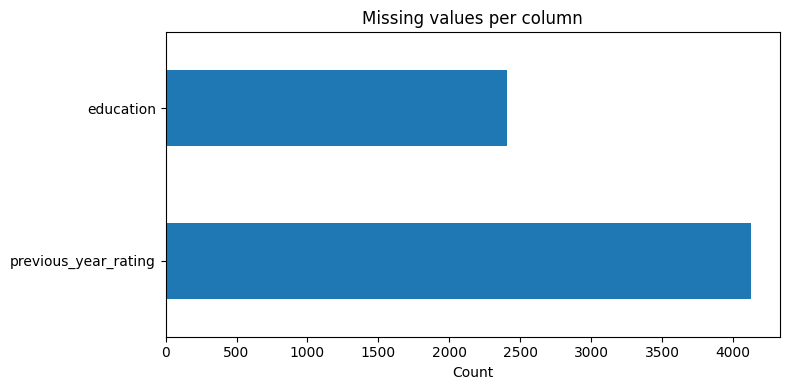

In [55]:
# Missing values (table + barplot)
missing = train.isnull().sum().sort_values(ascending=False)
missing = missing[missing > 0]
if not missing.empty:
    print("\nMissing values:\n", missing)
    plt.figure(figsize=(8,4))
    missing.plot(kind="barh", title="Missing values per column")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.show()

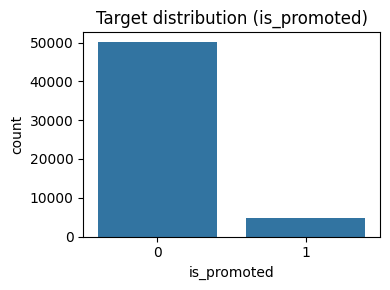


Target counts:
 is_promoted
0    50140
1     4668
Name: count, dtype: int64

Target ratio:
 is_promoted
0    0.91483
1    0.08517
Name: proportion, dtype: float64


In [56]:
#Target distribution (counts + % + plot)
plt.figure(figsize=(4,3))
sns.countplot(x=TARGET, data=train)
plt.title("Target distribution (is_promoted)")
plt.tight_layout()
plt.show()
print("\nTarget counts:\n", train[TARGET].value_counts())
print("\nTarget ratio:\n", train[TARGET].value_counts(normalize=True))

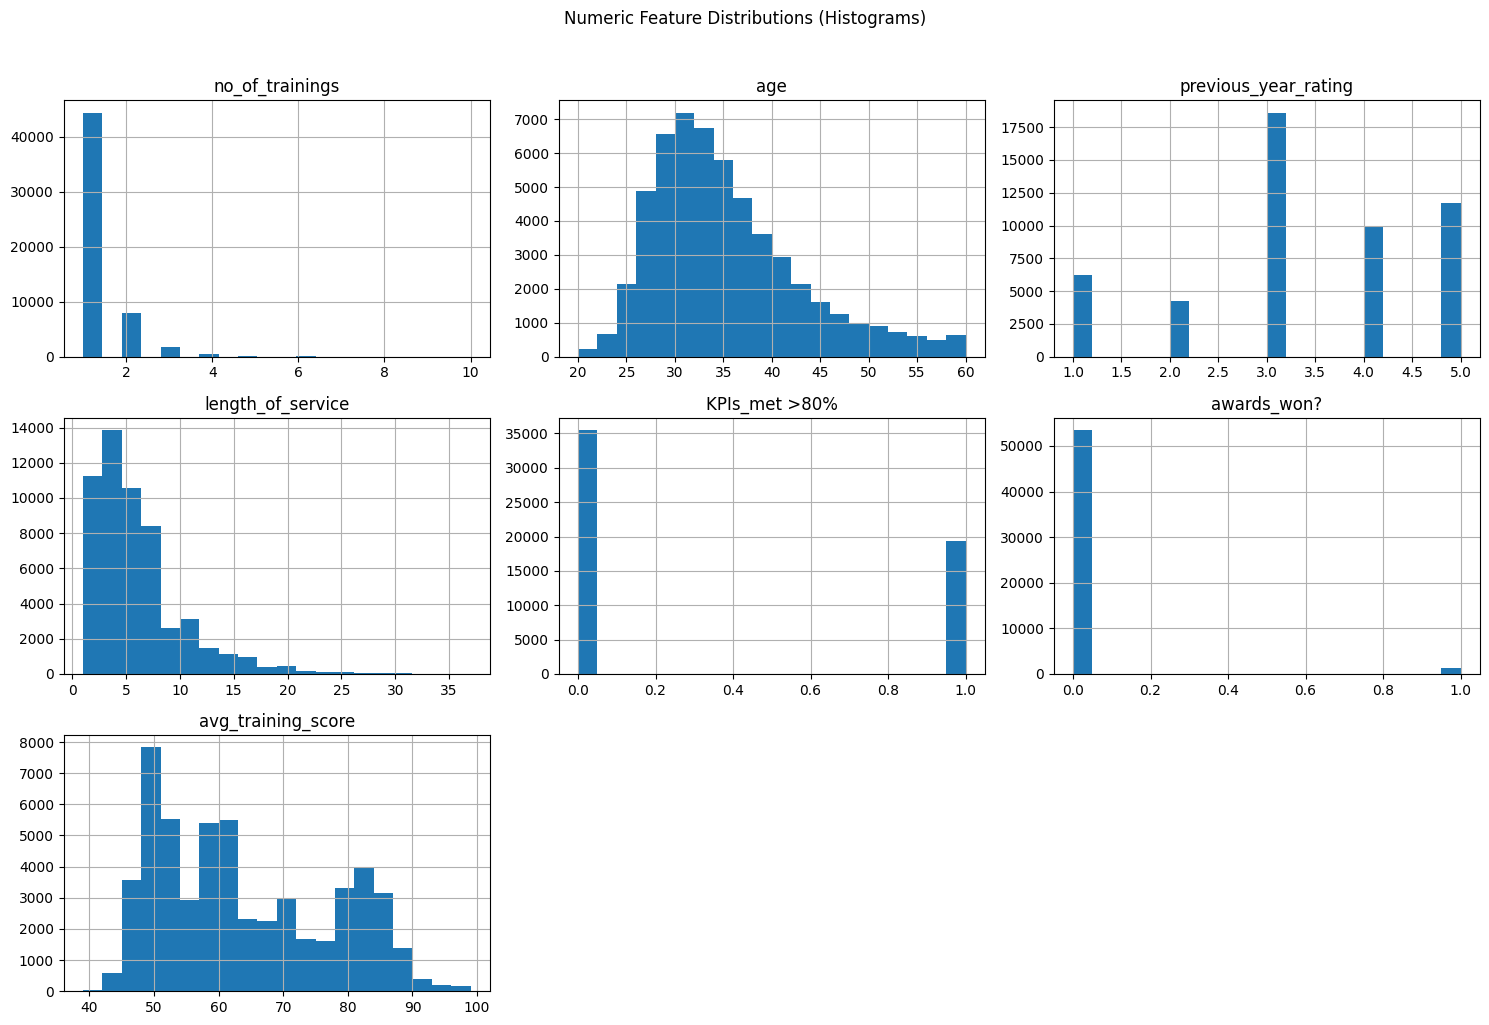

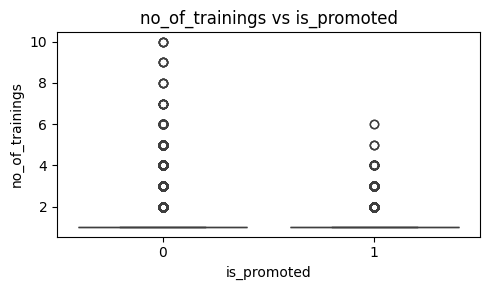

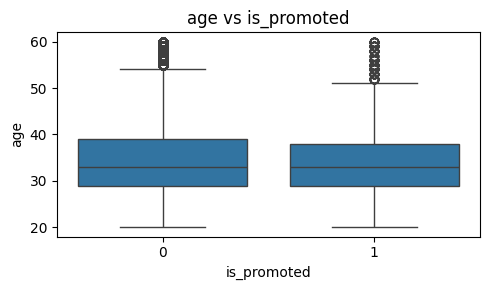

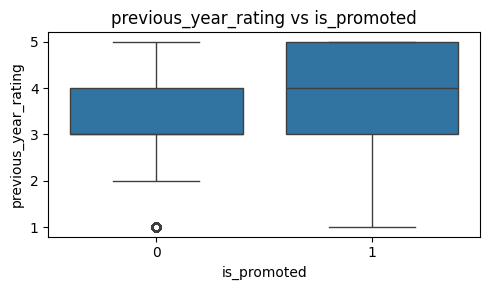

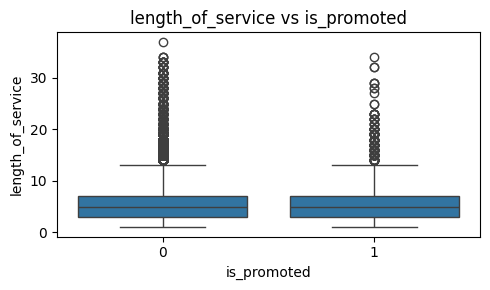

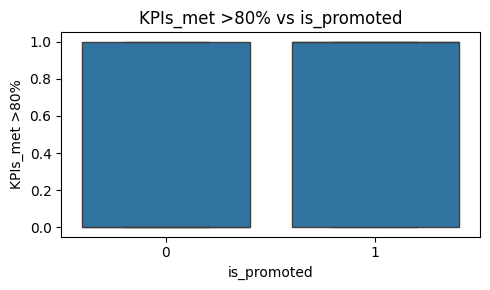

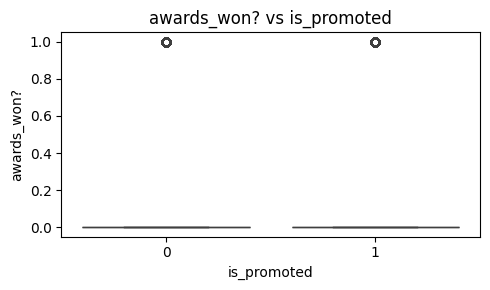

In [57]:
#Numeric feature distributions (histograms + boxplots vs target)
if len(num_cols) > 0:
    train[num_cols].hist(bins=20, figsize=(15,10))
    plt.suptitle("Numeric Feature Distributions (Histograms)", y=1.02)
    plt.tight_layout()
    plt.show()

    for col in num_cols[:6]:  # limit to first 6 for readability
        plt.figure(figsize=(5,3))
        sns.boxplot(x=TARGET, y=col, data=train)
        plt.title(f"{col} vs {TARGET}")
        plt.tight_layout()
        plt.show()


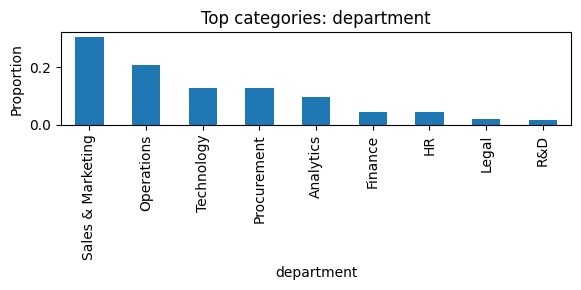

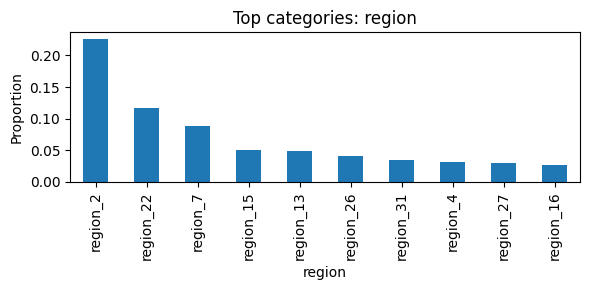

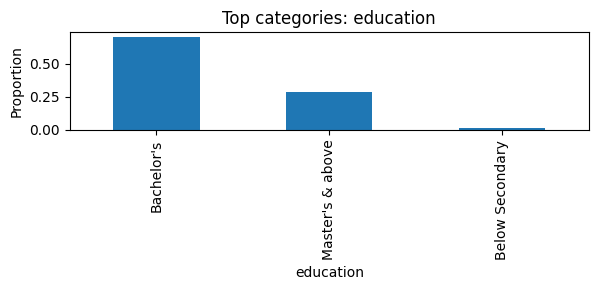

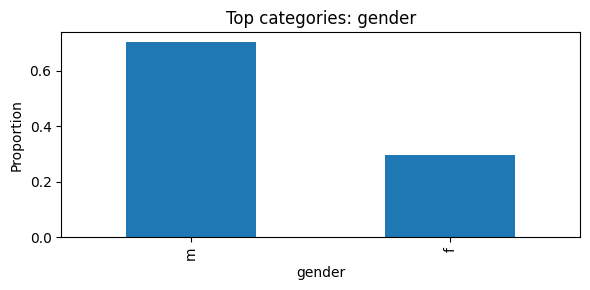

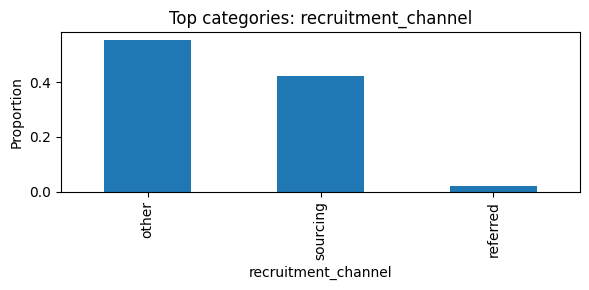

In [58]:
#Categorical feature distributions (barplots of top categories)
for col in cat_cols[:6]:  # limit to first 6
    plt.figure(figsize=(6,3))
    (train[col].value_counts(normalize=True)
         .head(10)
         .plot(kind="bar", title=f"Top categories: {col}"))
    plt.ylabel("Proportion")
    plt.tight_layout()
    plt.show()

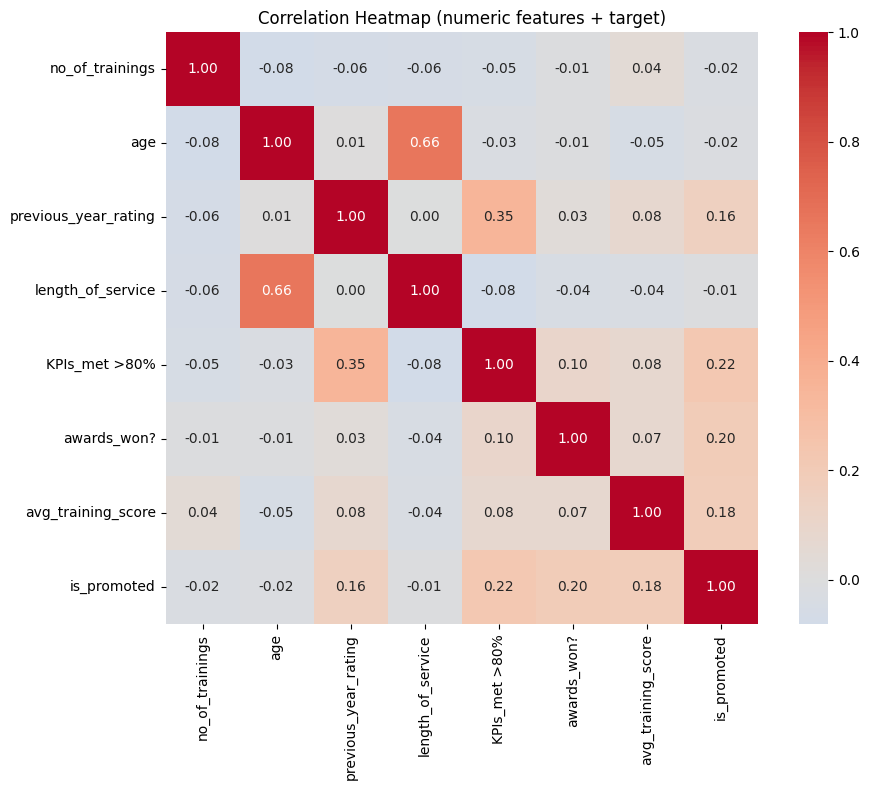

In [59]:
#Correlation heatmap (numeric + target)
if len(num_cols) > 0:
    corr = train[num_cols + [TARGET]].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    cbar=True,
    square=True
)

    plt.title("Correlation Heatmap (numeric features + target)")
    plt.tight_layout()
    plt.show()


Outlier report (IQR rule):
                  column  outlier_count  outlier_%
0       no_of_trainings          10430  19.030069
2  previous_year_rating           6223  11.354182
3     length_of_service           3489   6.365859
1                   age           1435   2.618231
5           awards_won?           1270   2.317180
4         KPIs_met >80%              0   0.000000
6    avg_training_score              0   0.000000


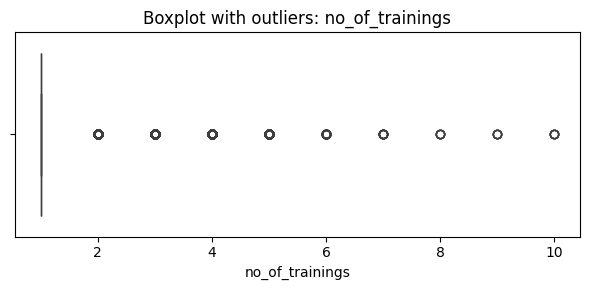

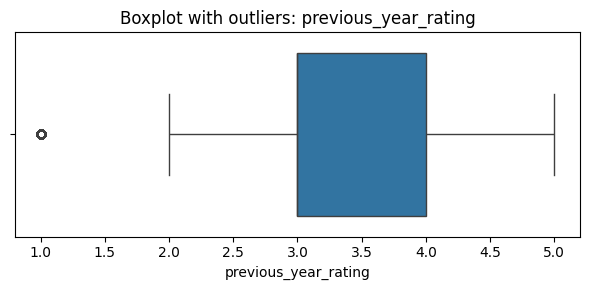

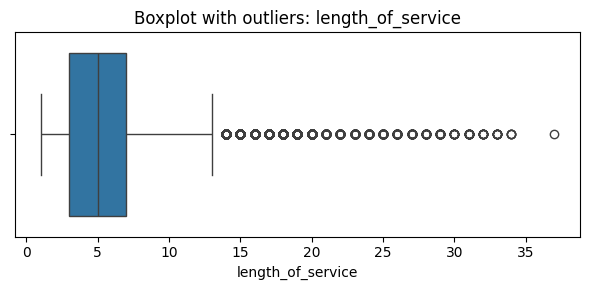

In [60]:
#Outlier diagnostics (IQR report + boxplots)
def iqr_outlier_report(df, cols):
    rows, n = [], len(df)
    for c in cols:
        x = pd.to_numeric(df[c], errors="coerce")
        q1, q3 = np.nanpercentile(x, [25, 75])
        iqr = q3 - q1
        lo, up = q1 - 1.5*iqr, q3 + 1.5*iqr
        cnt = ((x < lo) | (x > up)).sum()
        rows.append({"column": c, "outlier_count": int(cnt), "outlier_%": 100*cnt/n})
    return pd.DataFrame(rows).sort_values("outlier_%", ascending=False)

if len(num_cols) > 0:
    outlier_df = iqr_outlier_report(train, num_cols)
    print("\nOutlier report (IQR rule):\n", outlier_df.head(10))

    for col in outlier_df.head(3)["column"]:
        plt.figure(figsize=(6,3))
        sns.boxplot(x=train[col])
        plt.title(f"Boxplot with outliers: {col}")
        plt.tight_layout()
        plt.show()

In [61]:
# Preprocessing (percentile outlier capping)
# =========================================
class SimplePercentileCapper(BaseEstimator, TransformerMixin):
    def __init__(self, columns=None, lower_q=0.01, upper_q=0.99):
        self.columns = columns
        self.lower_q = lower_q
        self.upper_q = upper_q
        self.bounds_ = {}

    def fit(self, X, y=None):
        X_ = pd.DataFrame(X).copy()
        cols = self.columns or X_.columns.tolist()
        self.bounds_.clear()
        for c in cols:
            x = pd.to_numeric(X_[c], errors="coerce")
            lo = np.nanquantile(x, self.lower_q)
            up = np.nanquantile(x, self.upper_q)
            self.bounds_[c] = (lo, up)
        return self

    def transform(self, X):
        X_ = pd.DataFrame(X).copy()
        for c, (lo, up) in self.bounds_.items():
            if c in X_.columns:
                X_[c] = np.clip(pd.to_numeric(X_[c], errors="coerce"), lo, up)
        return X_

# Version-safe OneHotEncoder args for Colab
enc_kwargs = {"handle_unknown": "ignore"}
if version.parse(sklearn.__version__) < version.parse("1.2"):
    enc_kwargs["sparse"] = True  # older sklearn uses 'sparse' instead of 'sparse_output'

numeric = Pipeline(steps=[
    ("cap", SimplePercentileCapper(columns=num_cols, lower_q=0.01, upper_q=0.99)),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=False))  # safe with sparse downstream
])

categorical = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(**enc_kwargs))
])

preprocess = ColumnTransformer(transformers=[
    ("num", numeric, num_cols),
    ("cat", categorical, cat_cols),
])

In [62]:
#MODELS + CV

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

logreg = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs",
        random_state=RANDOM_STATE
    ))
])

rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300,             # bump to 600–1000 later if time allows
        max_depth=None,
        class_weight="balanced_subsample",
        random_state=RANDOM_STATE
    ))
])

def eval_cv(model, X, y, name):
    f1  = cross_val_score(model, X, y, cv=cv, scoring="f1_macro")
    acc = cross_val_score(model, X, y, cv=cv, scoring="accuracy")
    print(f"{name}\n  F1_macro: {f1.mean():.4f} ± {f1.std():.4f}\n  Accuracy: {acc.mean():.4f} ± {acc.std():.4f}\n")

print("\n>>> Cross-validation scores")
eval_cv(logreg, X, y, "Logistic Regression")
eval_cv(rf, X, y, "Random Forest")



>>> Cross-validation scores
Logistic Regression
  F1_macro: 0.6169 ± 0.0029
  Accuracy: 0.7692 ± 0.0036

Random Forest
  F1_macro: 0.7010 ± 0.0081
  Accuracy: 0.9351 ± 0.0012



In [64]:
#Fine-tuning (threshold on hold-out)

X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

rf_holdout = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        class_weight="balanced_subsample",
        random_state=RANDOM_STATE
    ))
])
rf_holdout.fit(X_tr, y_tr)

#Fine-tuning (threshold on hold-out)
proba = rf_holdout.predict_proba(X_va)[:, 1]
grid = np.linspace(0.2, 0.8, 25)
best_threshold, best_f1 = 0.5, -1
for t in grid:
    pred = (proba >= t).astype(int)
    f1 = f1_score(y_va, pred, average="macro")
    if f1 > best_f1:
        best_threshold, best_f1 = t, f1

print(f"Best threshold on hold-out: {best_threshold:.3f} | F1_macro={best_f1:.4f}")
pred = (proba >= best_threshold).astype(int)
print("Hold-out Accuracy:", accuracy_score(y_va, pred))
print("Hold-out ROC AUC :", roc_auc_score(y_va, proba))
print(confusion_matrix(y_va, pred))
print(classification_report(y_va, pred, digits=4))


Best threshold on hold-out: 0.350 | F1_macro=0.7226
Hold-out Accuracy: 0.9278416347381865
Hold-out ROC AUC : 0.8859983801245164
[[9800  228]
 [ 563  371]]
              precision    recall  f1-score   support

           0     0.9457    0.9773    0.9612     10028
           1     0.6194    0.3972    0.4840       934

    accuracy                         0.9278     10962
   macro avg     0.7825    0.6872    0.7226     10962
weighted avg     0.9179    0.9278    0.9206     10962



In [67]:
#Creating Submission using sample submission
best_model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        class_weight="balanced_subsample",
        random_state=RANDOM_STATE
    ))
])
best_model.fit(X, y)

test_proba = best_model.predict_proba(X_test_raw)[:, 1]
test_pred  = (test_proba >= best_threshold).astype(int)

# Use the provided sample submission template
final_sub = sample_sub.copy()
# sanity check: ensure row order aligns by ID
final_sub = final_sub[[ID_COL, TARGET]]
# fill predictions
final_sub[TARGET] = test_pred

final_sub.to_csv("final_submission.csv", index=False)
print("\nSaved: final_submission.csv")
print(final_sub.head())


Saved: final_submission.csv
   employee_id  is_promoted
0         8724            0
1        74430            0
2        72255            0
3        38562            0
4        64486            0


In [68]:
print(final_sub.sample(5))

       employee_id  is_promoted
1144         19947            0
14804        26282            0
9909         52244            0
19372        36756            1
45           49940            0


In [69]:
from google.colab import files
files.download("final_submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>